In [1]:
from utils import *

In [2]:
directory_path = './Data/fig13'

data_dict = read_data_dict(directory_path)
print(len(data_dict))

165


In [3]:
# Tag delay line parameters

delta_L1 = (72 - 3) * 0.0254
delta_L2 = (72 - 48) * 0.0254
delta_L3 = (48 - 3) * 0.0254
d = 0.1
speed_ratio = 0.7453

In [4]:
expected_ratios = [
    delta_L1 / delta_L3,  # Ratio 1 (L1 to L3)
    delta_L3 / delta_L2,   # Ratio 2 (L3 to L2)
    delta_L1 / delta_L2,   # Ratio 2 (L3 to L2)
]
tolerance = 0.6  # Tolerance for ratio matching

In [5]:
angle_w_slope = {}
slope_w_angle = {}
predicted_slopes = []
predicted_angles = []
gt_slopes = []
gt_angles = []

file_count = 0
for key in data_dict:
    data_obj = data_dict[key]
    theory_peak_1, theory_peak_2, theory_peak_3 = calculate_gt_frequency_peak(data_obj, delta_L1, delta_L2, delta_L3, d, c, speed_ratio)
    gt_peaks = theory_peak_1, theory_peak_2, theory_peak_3
    data = data_obj['data']
    gt_slope = data_obj['slope']
    gt_angle = data_obj['angle']
    file_count += 1
    timestamp = data[:, 0]
    amplitude = data[:, 1] * 1.0
    fs = len(timestamp) / ((timestamp[-1] - timestamp[0])) # timestamps in 1us
    _, _, valid_freq_list = find_beat_freq_triplet_with_expected_ratio(expected_ratios, tolerance, data_obj, radar_detection_mode = False, plot = False, return_snr = False, crop_to_list = True, fix_amplitude_order=True, noise_count = 10, noise_level = 7, window_length = 15)
    for predicted_peaks in valid_freq_list:
        if len(predicted_peaks) == 0:
            continue
        predicted_slope, predicted_angle = calculate_slope_and_angle(predicted_peaks, delta_L1, delta_L2, delta_L3, d, c, speed_ratio, frequency_offsets = [0, 1300, 0])
        predicted_slopes.append(predicted_slope)
        predicted_angles.append(predicted_angle)
        gt_slopes.append(gt_slope)
        gt_angles.append(gt_angle)
        
        if gt_slope not in angle_w_slope:
            angle_w_slope[gt_slope] = {}
        if gt_angle not in angle_w_slope[gt_slope]:
            angle_w_slope[gt_slope][gt_angle] = []
        angle_w_slope[gt_slope][gt_angle].append(predicted_angle)
        
        if gt_angle not in slope_w_angle:
            slope_w_angle[gt_angle] = {}
        if gt_slope not in slope_w_angle[gt_angle]:
            slope_w_angle[gt_angle][gt_slope] = []
        slope_w_angle[gt_angle][gt_slope].append(predicted_slope)

/Users/mtang/Documents/hidden-radar-detection/release/utils.py:841: RuntimeWarning: invalid value encountered in arcsin
  predicted_angle = np.rad2deg(np.arcsin(((predicted_peak2 * c) / predicted_slope - (delta_L2 / speed_ratio)) / (2*d)))


[0, -30, 40, 10, -20, -50, 50, 20, -10, -40, 30]


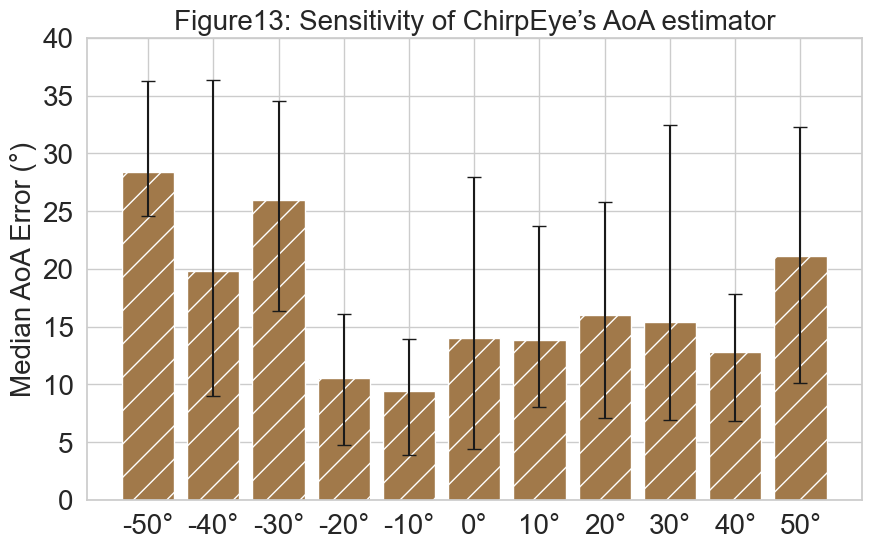

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib

color_map = sns.color_palette("cubehelix", 3).as_hex()

hatch_map = ['', '/', '//']

# Set seaborn style
sns.set(style="whitegrid")

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
font_size = 20

# Assuming predicted_values and gt_values are defined
predicted_values_array = np.array(predicted_angles)
predicted_values_array_offset = np.array(predicted_values_array)
gt_values = np.array(gt_angles)
print(list(set(gt_values)))
gt_values_unique = list(range(-50, 51, 10))

# Calculate errors for each unique gt value
errors_dict = {gt: np.abs(predicted_values_array_offset[gt_values == gt] - gt) for gt in gt_values_unique}

# Prepare data for the bar plot
errors_data = [errors_dict[gt][~np.isnan(errors_dict[gt])] for gt in gt_values_unique]

# Calculate median, Q1, and Q3 for each gt value
medians = [np.median(errors) for errors in errors_data if len(errors) > 0]
q1 = [np.percentile(errors, 25) for errors in errors_data if len(errors) > 0]
q3 = [np.percentile(errors, 75) for errors in errors_data if len(errors) > 0]

# Calculate the interquartile range for the error bars
iqr_error = [np.subtract(medians, q1), np.subtract(q3, medians)]

# Plot the median values with error bars showing the Q1 and Q3 range
plt.figure(figsize=(10, 6))
plt.bar(range(len(medians)), medians, yerr=iqr_error, capsize=5, align='center', color=color_map[1], hatch=hatch_map[1])
plt.xticks(range(len(medians)), [f'{gt}°' for gt in gt_values_unique], rotation=0, fontsize=font_size)
plt.yticks(fontsize=font_size)
# plt.xlabel('Ground Truth Angle Value', fontsize=font_size)
plt.ylabel('Median AoA Error (°)', fontsize=font_size)
plt.title('Figure13: Sensitivity of ChirpEye’s AoA estimator', fontsize=font_size)
plt.ylim(0, 40)
plt.grid(True)
# plt.savefig('Figures/new_angle_median_error_diff_angle.pdf', dpi=300, bbox_inches='tight')
plt.show()